In [12]:
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction as GC
from Bio.Seq import Seq
from collections import defaultdict, Counter
from IPython.display import display, HTML

In [13]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

In [14]:
GENBANK_DIR = "../../data/ncbi_data/gen_bank/train/Lysogneic/Group1"  # Thay đổi đường dẫn này
OUTPUT_DIR = "phage_analysis_results"       # Thư mục lưu kết quả
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [15]:
def analyze_genbank_file(file_path):
    """Phân tích một file GenBank và trả về thông tin cần thiết"""
    try:
        # Đọc file GenBank
        record = SeqIO.read(file_path, "genbank")
        
        # Thông tin cơ bản về genome
        basic_info = {
            "file_name": os.path.basename(file_path),
            "accession": record.id,
            "name": record.name,
            "description": record.description,
            "length": len(record.seq),
            "gc_content": GC(record.seq),
            "num_features": len(record.features)
        }
        
        # Thông tin về các gene và protein
        genes_data = []
        feature_types = Counter()
        
        # Đếm số lượng gene theo loại và chức năng
        functional_categories = {
            "Cấu trúc đầu": ["head", "capsid", "portal", "terminase"],
            "Cấu trúc đuôi": ["tail", "fiber", "baseplate", "tape measure"],
            "DNA replication": ["dna", "polymerase", "helicase", "primase", "replication"],
            "Lysis": ["lysin", "holin", "endolysin", "lysis"],
            "Lysogeny": ["integrase", "excisionase", "repressor", "immunity"],
            "Host specificity": ["receptor", "binding", "adhesin", "tail fiber"],
            "Metabolism": ["metabolism", "synthetase", "kinase", "phosphatase"],
            "Chưa xác định": []
        }
        
        # Đếm marker genes cho việc phân loại kiểu sống
        temperate_markers = ["integrase", "excisionase", "repressor", "xis", "int", "immunity", "lysogeny"]
        virulent_markers = ["early", "middle", "late", "lysis", "endolysin", "virulent"]
        
        temperate_count = 0
        virulent_count = 0
        
        # Phân tích các gene và protein
        for feature in record.features:
            # Đếm loại feature
            feature_types[feature.type] += 1
            
            # Xử lý feature CDS (coding sequence)
            if feature.type == "CDS":
                # Thu thập thông tin về gene/protein
                locus_tag = feature.qualifiers.get("locus_tag", ["Unknown"])[0]
                gene_name = feature.qualifiers.get("gene", ["Unknown"])[0]
                product = feature.qualifiers.get("product", ["Unknown"])[0]
                protein_id = feature.qualifiers.get("protein_id", ["Unknown"])[0]
                translation = feature.qualifiers.get("translation", [""])[0]
                
                # Xác định chức năng dựa trên mô tả sản phẩm
                product_lower = product.lower()
                category = "Chưa xác định"
                
                for cat, keywords in functional_categories.items():
                    for keyword in keywords:
                        if keyword in product_lower:
                            category = cat
                            break
                    if category != "Chưa xác định":
                        break
                
                # Kiểm tra marker genes cho virulent/temperate
                for marker in temperate_markers:
                    if marker in product_lower or marker in gene_name.lower():
                        temperate_count += 1
                        break
                        
                for marker in virulent_markers:
                    if marker in product_lower or marker in gene_name.lower():
                        virulent_count += 1
                        break
                
                # Thông tin gene
                gene_info = {
                    "locus_tag": locus_tag,
                    "gene_name": gene_name,
                    "product": product,
                    "protein_id": protein_id,
                    "start": int(feature.location.start),
                    "end": int(feature.location.end),
                    "strand": "+" if feature.location.strand == 1 else "-",
                    "length": len(feature.location),
                    "category": category,
                    "protein_length": len(translation) if translation else 0
                }
                genes_data.append(gene_info)
        
        # Dự đoán kiểu sống của thực khuẩn
        lifestyle = "Không xác định"
        lifestyle_confidence = 0
        
        if temperate_count > virulent_count:
            lifestyle = "Temperate"
            lifestyle_confidence = temperate_count / (temperate_count + virulent_count) if (temperate_count + virulent_count) > 0 else 0
        elif virulent_count > temperate_count:
            lifestyle = "Virulent"
            lifestyle_confidence = virulent_count / (temperate_count + virulent_count) if (temperate_count + virulent_count) > 0 else 0
        
        # Kết quả phân tích
        result = {
            "basic_info": basic_info,
            "genes_df": pd.DataFrame(genes_data) if genes_data else pd.DataFrame(),
            "feature_types": feature_types,
            "temperate_markers": temperate_count,
            "virulent_markers": virulent_count,
            "predicted_lifestyle": lifestyle,
            "lifestyle_confidence": lifestyle_confidence
        }
        
        return result
    
    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {str(e)}")
        return None

def process_genbank_files():
    """Xử lý tất cả các file GenBank trong thư mục"""
    # Tìm tất cả file GenBank trong thư mục
    gb_files = glob.glob(os.path.join(GENBANK_DIR, "*.gb"))
    
    if not gb_files:
        print(f"Không tìm thấy file GenBank trong thư mục {GENBANK_DIR}")
        return None
    
    print(f"Tìm thấy {len(gb_files)} file GenBank. Đang xử lý...")
    
    # Phân tích từng file
    all_results = []
    for i, file_path in enumerate(gb_files):
        print(f"Đang xử lý file {i+1}/{len(gb_files)}: {os.path.basename(file_path)}")
        result = analyze_genbank_file(file_path)
        if result:
            all_results.append(result)
    
    print(f"Đã xử lý xong {len(all_results)}/{len(gb_files)} file GenBank.")
    return all_results

In [16]:
def analyze_and_visualize(all_results):
    """Phân tích tổng hợp và tạo đồ thị từ kết quả"""
    if not all_results:
        print("Không có dữ liệu để phân tích.")
        return
    
    # Tạo DataFrame với thông tin cơ bản
    basic_info_list = [r["basic_info"] for r in all_results]
    basic_df = pd.DataFrame(basic_info_list)
    
    # Tạo DataFrame tổng hợp với thông tin về lifestyle
    lifestyle_data = []
    for r in all_results:
        lifestyle_info = {
            "accession": r["basic_info"]["accession"],
            "name": r["basic_info"]["name"],
            "length": r["basic_info"]["length"],
            "gc_content": r["basic_info"]["gc_content"],
            "num_features": r["basic_info"]["num_features"],
            "temperate_markers": r["temperate_markers"],
            "virulent_markers": r["virulent_markers"],
            "predicted_lifestyle": r["predicted_lifestyle"],
            "lifestyle_confidence": r["lifestyle_confidence"]
        }
        lifestyle_data.append(lifestyle_info)
    
    lifestyle_df = pd.DataFrame(lifestyle_data)
    
    # Lưu dữ liệu cơ bản
    basic_df.to_csv(os.path.join(OUTPUT_DIR, "phage_basic_info.csv"), index=False)
    lifestyle_df.to_csv(os.path.join(OUTPUT_DIR, "phage_lifestyle_prediction.csv"), index=False)
    
    # Tổng hợp dữ liệu tất cả gene từ tất cả các phage
    all_genes_data = []
    for r in all_results:
        if not r["genes_df"].empty:
            # Thêm accession để biết gene thuộc phage nào
            genes_df = r["genes_df"].copy()
            genes_df["accession"] = r["basic_info"]["accession"]
            genes_df["phage_name"] = r["basic_info"]["name"]
            genes_df["predicted_lifestyle"] = r["predicted_lifestyle"]
            all_genes_data.append(genes_df)
    
    # Tạo DataFrame chứa tất cả gene
    if all_genes_data:
        all_genes_df = pd.concat(all_genes_data, ignore_index=True)
        all_genes_df.to_csv(os.path.join(OUTPUT_DIR, "all_phage_genes.csv"), index=False)
    else:
        all_genes_df = pd.DataFrame()
    
    # Thống kê và trực quan hóa
    print("Tạo đồ thị và báo cáo...")
    
    # 1. Phân bố kích thước genome
    plt.figure(figsize=(10, 6))
    sns.histplot(basic_df["length"], kde=True)
    plt.title("Phân bố kích thước genome của thực khuẩn")
    plt.xlabel("Kích thước (bp)")
    plt.ylabel("Số lượng")
    plt.savefig(os.path.join(OUTPUT_DIR, "genome_size_distribution.png"), dpi=300, bbox_inches="tight")
    
    # 2. Phân bố GC content
    plt.figure(figsize=(10, 6))
    sns.histplot(basic_df["gc_content"], kde=True)
    plt.title("Phân bố GC content của thực khuẩn")
    plt.xlabel("GC Content (%)")
    plt.ylabel("Số lượng")
    plt.savefig(os.path.join(OUTPUT_DIR, "gc_content_distribution.png"), dpi=300, bbox_inches="tight")
    
    # 3. Dự đoán lifestyle
    plt.figure(figsize=(8, 6))
    lifestyle_counts = lifestyle_df["predicted_lifestyle"].value_counts()
    sns.barplot(x=lifestyle_counts.index, y=lifestyle_counts.values)
    plt.title("Dự đoán kiểu sống của thực khuẩn")
    plt.xlabel("Kiểu sống")
    plt.ylabel("Số lượng")
    plt.savefig(os.path.join(OUTPUT_DIR, "lifestyle_prediction.png"), dpi=300, bbox_inches="tight")
    
    # 4. Mối quan hệ giữa GC content và kích thước genome, phân biệt theo lifestyle
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(data=lifestyle_df, x="gc_content", y="length", hue="predicted_lifestyle", 
                               size="num_features", sizes=(50, 200), alpha=0.7)
    plt.title("Mối quan hệ giữa GC content và kích thước genome")
    plt.xlabel("GC Content (%)")
    plt.ylabel("Kích thước genome (bp)")
    plt.legend(title="Kiểu sống")
    plt.savefig(os.path.join(OUTPUT_DIR, "gc_vs_size_by_lifestyle.png"), dpi=300, bbox_inches="tight")
    
    # 5. Phân bố chức năng gene (nếu có dữ liệu gene)
    if not all_genes_df.empty and "category" in all_genes_df.columns:
        plt.figure(figsize=(12, 6))
        category_counts = all_genes_df["category"].value_counts()
        sns.barplot(x=category_counts.index, y=category_counts.values)
        plt.title("Phân bố chức năng của gene trong thực khuẩn")
        plt.xlabel("Phân loại chức năng")
        plt.ylabel("Số lượng gene")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "gene_function_distribution.png"), dpi=300, bbox_inches="tight")
        
        # 6. Phân bố chức năng gene theo lifestyle
        plt.figure(figsize=(14, 8))
        function_by_lifestyle = pd.crosstab(all_genes_df["category"], all_genes_df["predicted_lifestyle"])
        function_by_lifestyle.plot(kind="bar", stacked=False)
        plt.title("Phân bố chức năng gene theo kiểu sống")
        plt.xlabel("Phân loại chức năng")
        plt.ylabel("Số lượng gene")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Kiểu sống")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "gene_function_by_lifestyle.png"), dpi=300, bbox_inches="tight")
    
    print(f"Đã lưu các kết quả phân tích vào thư mục: {OUTPUT_DIR}")
    return {
        "basic_df": basic_df,
        "lifestyle_df": lifestyle_df,
        "all_genes_df": all_genes_df
    }

In [17]:
def advanced_analysis(all_results):
    """Thực hiện các phân tích nâng cao về codon usage và đặc điểm phân tử"""
    if not all_results:
        print("Không có dữ liệu để phân tích nâng cao.")
        return
    
    print("Đang thực hiện phân tích nâng cao...")
    
    # Phân tích Codon Usage
    codon_usage_by_phage = {}
    
    for result in all_results:
        record_id = result["basic_info"]["accession"]
        
        # Lấy dữ liệu từ file GenBank
        file_path = os.path.join(GENBANK_DIR, result["basic_info"]["file_name"])
        try:
            record = SeqIO.read(file_path, "genbank")
            
            # Khởi tạo từ điển đếm codon
            codon_count = defaultdict(int)
            
            # Duyệt qua các CDS feature
            for feature in record.features:
                if feature.type == "CDS" and "translation" in feature.qualifiers:
                    # Lấy trình tự nucleotide của CDS
                    if feature.location.strand == 1:
                        seq = feature.extract(record.seq)
                    else:
                        seq = feature.extract(record.seq).reverse_complement()
                    
                    # Đếm codon
                    for i in range(0, len(seq) - 2, 3):
                        codon = str(seq[i:i+3]).upper()
                        if len(codon) == 3 and "N" not in codon:
                            codon_count[codon] += 1
            
            codon_usage_by_phage[record_id] = codon_count
            
        except Exception as e:
            print(f"Lỗi khi phân tích codon usage cho {record_id}: {str(e)}")
    
    # Tạo DataFrame codon usage tổng hợp
    if codon_usage_by_phage:
        # Lấy tất cả các codon có thể có
        all_codons = set()
        for counts in codon_usage_by_phage.values():
            all_codons.update(counts.keys())
        
        # Tạo DataFrame
        codon_df_data = {}
        for phage_id, counts in codon_usage_by_phage.items():
            # Tính tần suất sử dụng codon
            total_codons = sum(counts.values())
            codon_freq = {codon: count/total_codons*1000 for codon, count in counts.items()} if total_codons > 0 else {}
            
            # Thêm các codon còn thiếu
            for codon in all_codons:
                if codon not in codon_freq:
                    codon_freq[codon] = 0
            
            codon_df_data[phage_id] = codon_freq
        
        codon_usage_df = pd.DataFrame(codon_df_data).T
        codon_usage_df.to_csv(os.path.join(OUTPUT_DIR, "codon_usage.csv"))
        
        # Trực quan hóa codon usage
        plt.figure(figsize=(15, 10))
        
        # Lấy giá trị trung bình cho mỗi codon
        avg_codon_usage = codon_usage_df.mean().sort_values(ascending=False)
        top_codons = avg_codon_usage.index[:20]  # Top 20 codon
        
        # Vẽ biểu đồ top 20 codon
        sns.barplot(x=top_codons, y=avg_codon_usage[top_codons])
        plt.title("Top 20 codon được sử dụng nhiều nhất (trung bình)")
        plt.xlabel("Codon")
        plt.ylabel("Tần suất (trên 1000 codon)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "top_codons_usage.png"), dpi=300, bbox_inches="tight")
        
        # Phân tích PCA của codon usage
        try:
            from sklearn.decomposition import PCA
            from sklearn.preprocessing import StandardScaler
            
            # Chuẩn hóa dữ liệu
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(codon_usage_df)
            
            # Thực hiện PCA
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(scaled_data)
            
            # Tạo DataFrame với kết quả PCA
            pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
            pca_df['phage_id'] = codon_usage_df.index
            
            # Thêm thông tin về lifestyle
            lifestyle_df = pd.DataFrame([
                {"phage_id": r["basic_info"]["accession"], 
                 "lifestyle": r["predicted_lifestyle"]} 
                for r in all_results
            ])
            
            pca_df = pd.merge(pca_df, lifestyle_df, on="phage_id", how="left")
            
            # Vẽ biểu đồ PCA
            plt.figure(figsize=(10, 8))
            sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="lifestyle", s=100, alpha=0.8)
            plt.title("PCA của Codon Usage")
            plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
            plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_DIR, "codon_usage_pca.png"), dpi=300, bbox_inches="tight")
            
            print("Đã hoàn thành phân tích PCA codon usage.")
            
        except Exception as e:
            print(f"Lỗi khi thực hiện PCA: {str(e)}")
    
    return

Tìm thấy 118 file GenBank. Đang xử lý...
Đang xử lý file 1/118: train_NC_000902_Lysogneic_Group1.gb
Đang xử lý file 2/118: train_NC_000935_Lysogneic_Group1.gb
Đang xử lý file 3/118: train_NC_001396_Lysogneic_Group1.gb
Đang xử lý file 4/118: train_NC_001416_Lysogneic_Group1.gb
Đang xử lý file 5/118: train_NC_001418_Lysogneic_Group1.gb
Đang xử lý file 6/118: train_NC_001697_Lysogneic_Group1.gb
Đang xử lý file 7/118: train_NC_001895_Lysogneic_Group1.gb
Đang xử lý file 8/118: train_NC_002666_Lysogneic_Group1.gb
Đang xử lý file 9/118: train_NC_002669_Lysogneic_Group1.gb
Đang xử lý file 10/118: train_NC_002671_Lysogneic_Group1.gb
Đang xử lý file 11/118: train_NC_002703_Lysogneic_Group1.gb
Đang xử lý file 12/118: train_NC_002730_Lysogneic_Group1.gb
Đang xử lý file 13/118: train_NC_003085_Lysogneic_Group1.gb
Đang xử lý file 14/118: train_NC_003157_Lysogneic_Group1.gb
Đang xử lý file 15/118: train_NC_003313_Lysogneic_Group1.gb
Đang xử lý file 16/118: train_NC_003315_Lysogneic_Group1.gb
Đang xử 

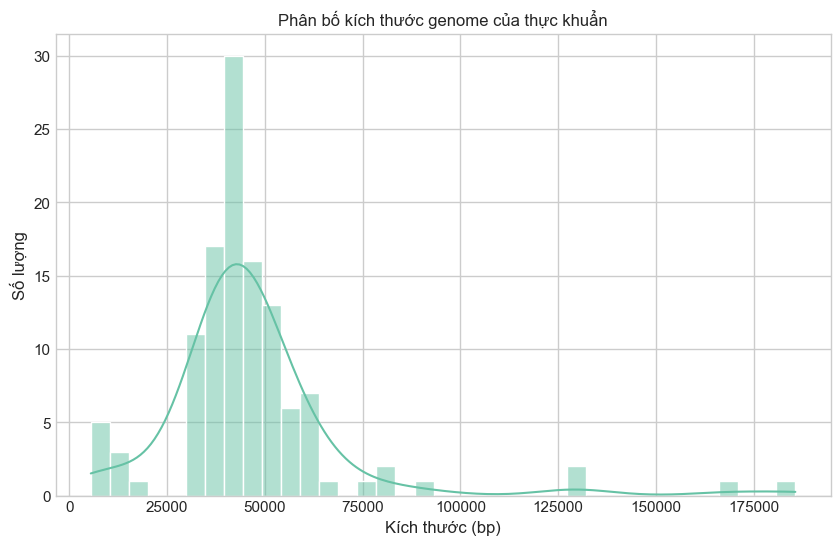

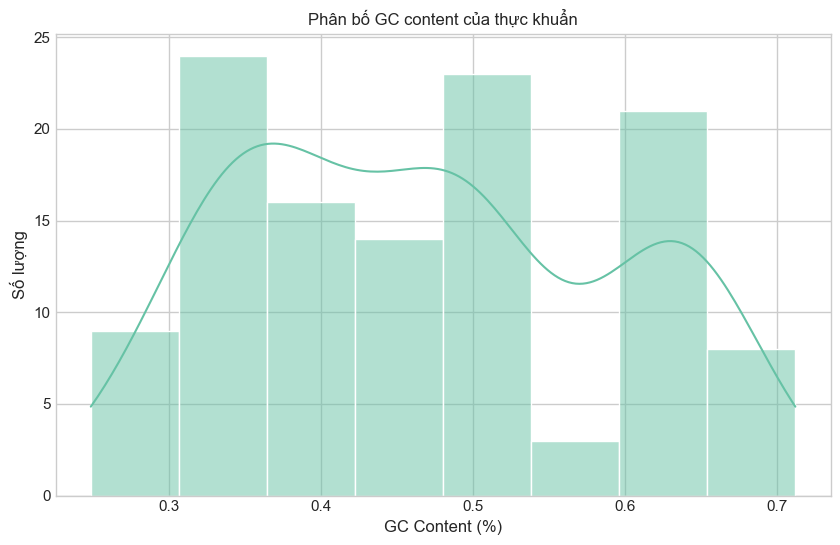

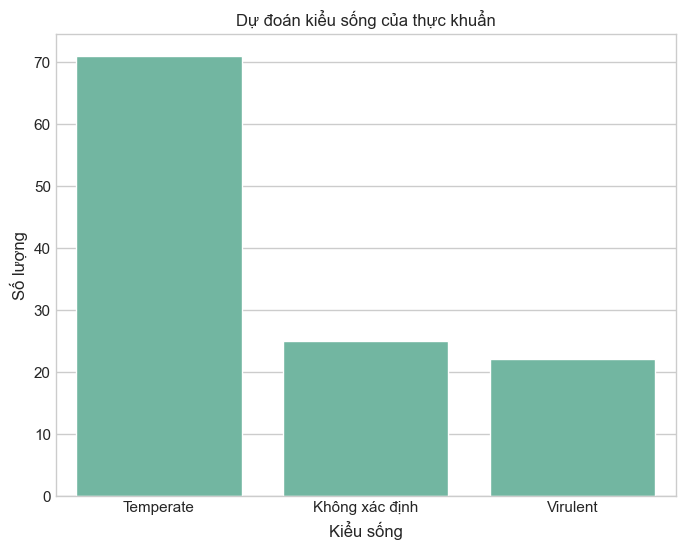

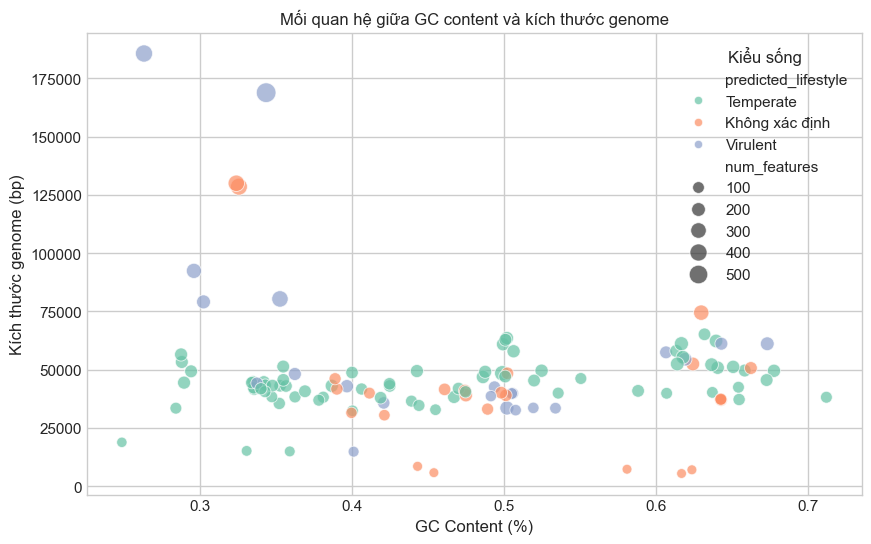

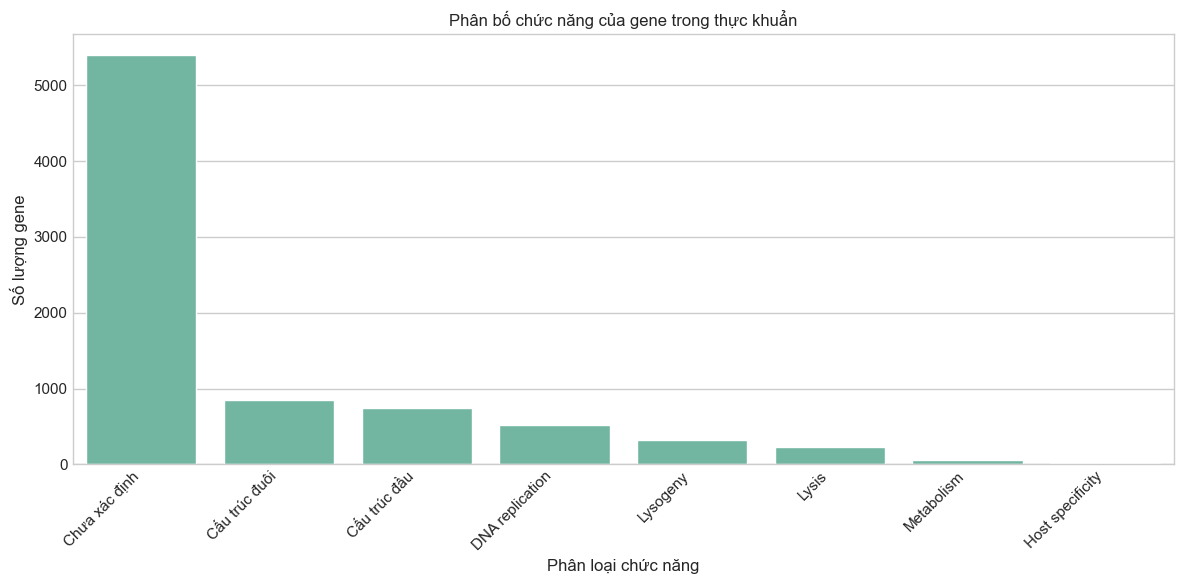

<Figure size 1400x800 with 0 Axes>

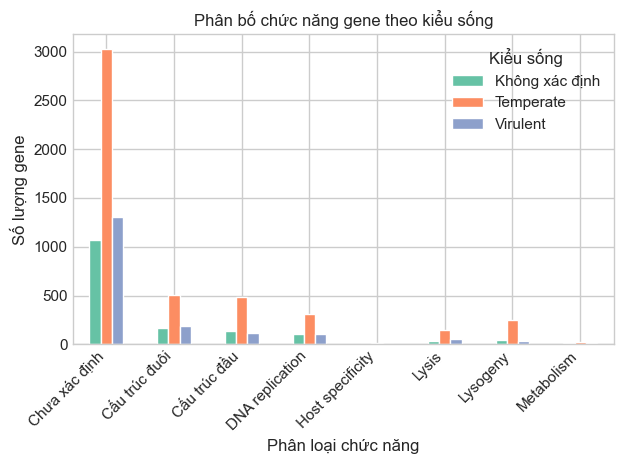

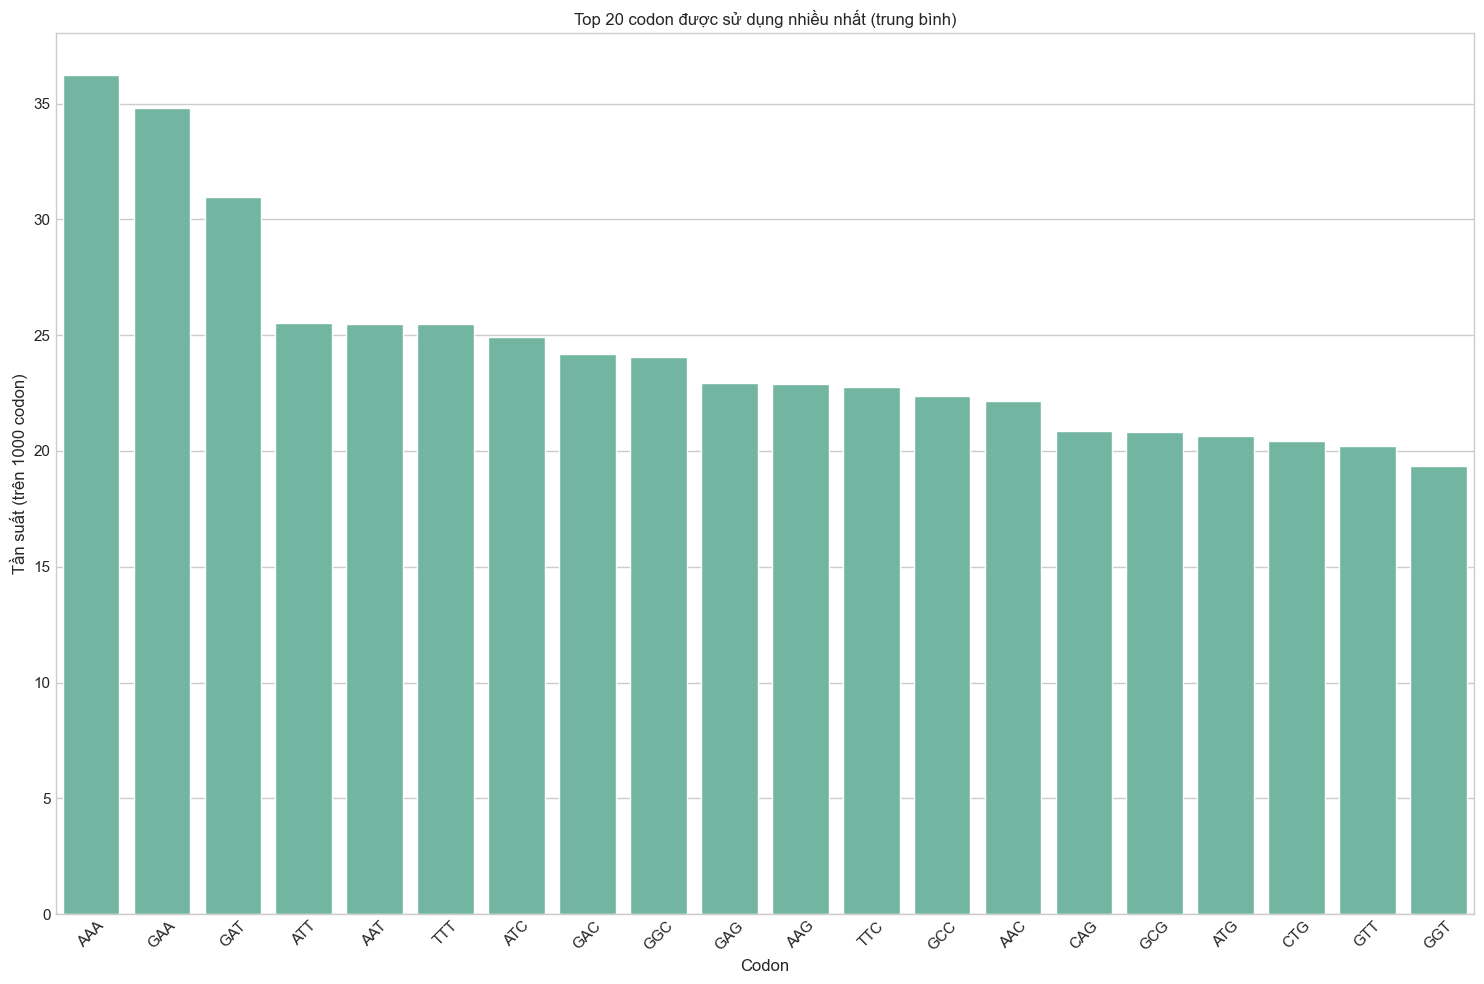

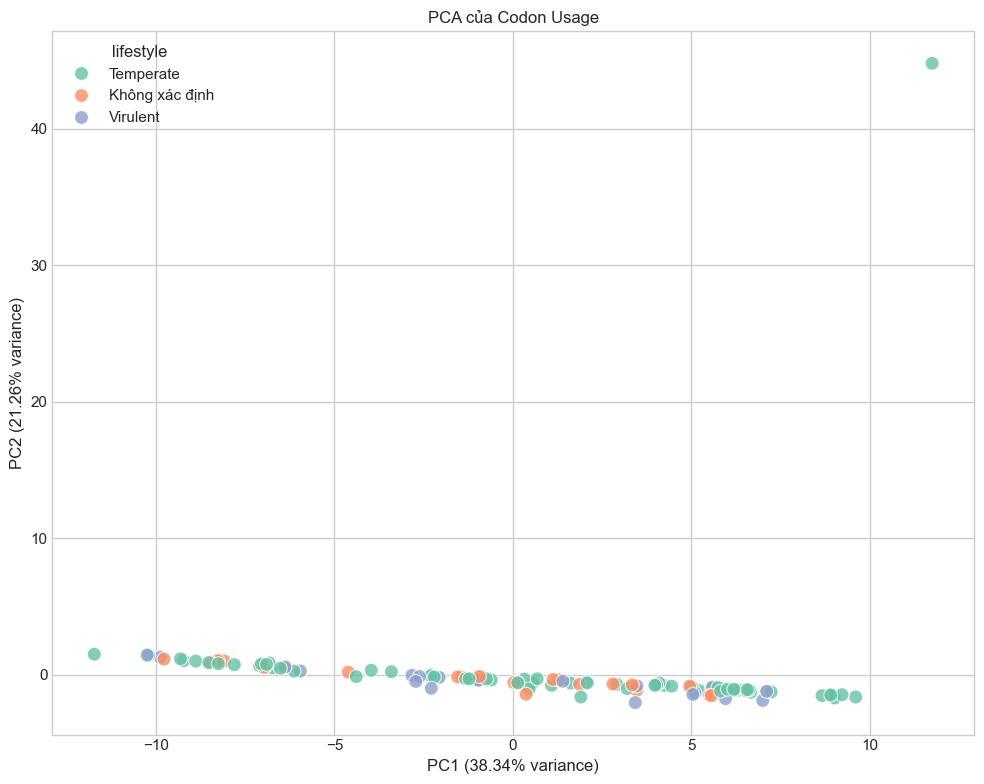

In [18]:
# Xử lý tất cả các file GenBank
all_results = process_genbank_files()

if all_results:
    # Phân tích và trực quan hóa kết quả
    data_frames = analyze_and_visualize(all_results)
    
    # Phân tích nâng cao
    advanced_analysis(all_results)
    
    print("Phân tích hoàn tất!")
    
    # Trả về DataFrames cho người dùng có thể tiếp tục phân tích
    # return data_frames
else:
    print("Không có kết quả để phân tích.")
    # return None